# Part I: Profiling expression STRs across 17 human tissues

In [87]:
# Set up
%pylab inline

# Params
DATADIR = "/storage/mgymrek/gtex-estrs/revision/"
RESULTSDIR = "/storage/mgymrek/gtex-estrs/revision/figures"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.stats.multitest

############ Set up paths #############
SAVEPLOT = True
FIGPREFIX = "Figure1"

############ Tissue info ##############
COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
    "permuted": "gray"
}

SHORTEN = {
    "Artery-Aorta":"Artery A."     ,
    "Artery-Tibial": "Artery T.",
    "Adipose-Subcutaneous": "Adipose S.",    
    "Adipose-Visceral":"Adipose V.",
    "Brain-Caudate":"Caudate"   , 
    "Brain-Cerebellum":"Cerebellum",
    "Cells-Transformedfibroblasts": "Fibroblast",
    "Esophagus-Mucosa": "E. Mucosa",
    "Esophagus-Muscularis":"E Muscularis",
    "Heart-LeftVentricle":"Ventricle",
    "Lung": "Lung",
    "Muscle-Skeletal": "Muscle",
    "Nerve-Tibial":"Nerve",
    "Skin-NotSunExposed": "Skin Unexposed",
    "Skin-SunExposed":"Skin Leg",
    "Thyroid":"Thyroid",
    "WholeBlood": "Blood",
    "permuted":"Permuted",
    "LCL": "LCL"
}
TISSUES = [item for item in list(COLORS.keys()) if item != "permuted"]

############ Load data ################
NGESTR = pd.read_csv(os.path.join(DATADIR, "misc", "2016_estrs_table.csv"))

# Linear regression data
master = {} # Map of tissue -> data
for t in TISSUES:
    master[t] = pd.read_csv(os.path.join(DATADIR, "mastertables", "%s_master.tab"%t), sep="\t", 
                            usecols=["gene","str.start","linreg.beta","linreg.pval","caviar.str.score","mashr.significant"])
    # Reformat gene names and start coords
    master[t]["gene"] = master[t]["gene"].apply(lambda x: x.split(".")[0])
    master[t]["signif_%s"%t] = master[t]["mashr.significant"]
master["permuted"] = pd.read_csv(os.path.join(DATADIR, "strreg","WholeBlood_strreg_permuted.tab"), sep="\t")
master["permuted"]["linreg.pval"] = master["permuted"]["p.wald"]
master["LCL"] = NGESTR

master["LCL"]["str.id"] = master["LCL"]["str.start"].apply(lambda x: "STR_%s"%(x-1))
master["LCL"]["significant"] = master["LCL"]["signif.estr"]

betas = pd.read_csv(os.path.join(DATADIR, "mashr", "output-strs", "posterior_betas.tsv"), sep="\t", index_col=0)
beta_ses = pd.read_csv(os.path.join(DATADIR, "mashr", "output-strs", "posterior_beta_ses.tsv"), sep="\t", index_col=0)
zscores = pd.read_csv(os.path.join(DATADIR, "mashr", "output-strs", "zscores.tsv"), sep="\t", index_col=0)
ntissues = len(betas.columns)

NOMTHRESH = 10**-4
ZTHRESH = 3

Populating the interactive namespace from numpy and matplotlib


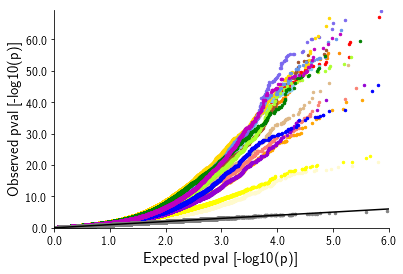

In [15]:
# Figure 1B: QQ Plot

TISSUES = sorted(TISSUES)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
maxval = 0
for t in TISSUES + ["permuted"]:
    dt = master[t][["linreg.pval"]].copy()
    dt = dt[~np.isnan(dt["linreg.pval"])]
    unif = sorted(list(np.random.uniform(low=0, high=1, size=dt.shape[0])))
    unif_log = [-1*np.log10(x) for x in unif]
    pvals = sorted(list(dt["linreg.pval"]))
    pvals_log = [-1*np.log10(x) for x in pvals]
    maxval = max([maxval]+pvals_log)
    ax.scatter(unif_log, pvals_log, color=COLORS[t], label=SHORTEN[t], s=6)
ax.plot([0,6],[0,6], color="black")
ax.set_xlim(left=0, right=6)
ax.set_ylim(bottom=0, top=maxval/5*5)
ax.set_xlabel("Expected pval [-log10(p)]", size=15)
ax.set_ylabel("Observed pval [-log10(p)]", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "%s_qqplot.png"%FIGPREFIX))

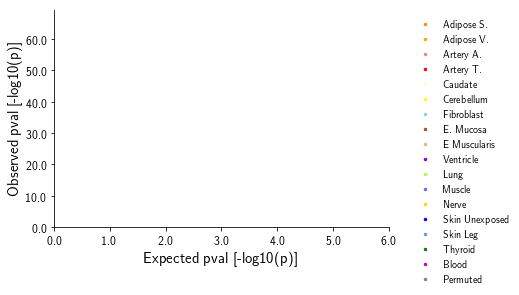

In [16]:
# Additionally plot the skeleton as pdf to use in Illustrator
fig = plt.figure()
ax = fig.add_subplot(111)
for t in TISSUES + ["permuted"]:
    ax.scatter([],[], color=COLORS[t], label=SHORTEN[t], s=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlim(left=0, right=6)
ax.set_ylim(bottom=0, top=maxval/5*5)
ax.set_xlabel("Expected pval [-log10(p)]", size=15)
ax.set_ylabel("Observed pval [-log10(p)]", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False);
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "%s_qqplot_skeleton.pdf"%FIGPREFIX))

In [43]:
#### Stats ####
numgenes = []
numtests = []
numsig_mashr = {}
numsig_nom = {}
num_samples = {}

# Keep track of number of unique eSTRs
starts = []
genes = []

for t in TISSUES:
    d = master[t]
    numgenes.append(len(set(d[~np.isnan(d["linreg.pval"])]["gene"])))
    numtests.append(d[~np.isnan(d["linreg.pval"])].shape[0])
    numsig_mashr[t] = sum(d["mashr.significant"] & ~np.isnan(d["linreg.pval"]))
    numsig_nom[t] = sum((d["linreg.pval"]<NOMTHRESH) & ~np.isnan(d["linreg.pval"]))
    num_samples[t] = len(open(os.path.join(DATADIR,"samples","%s.samples"%t), "r").readlines())
    estrs = d[d["mashr.significant"]]
    starts.extend(list(estrs["str.start"]))
    genes.extend(list(estrs["gene"]))

print("Mean num genes tested per tissue: %s"%np.mean(numgenes))
print("Mean num STRxgene tests per tissue: %s"%np.mean(numtests))

# Number of unique eSTRs
allestrs = pd.DataFrame({"str.start": starts, "gene": genes}).drop_duplicates()
print("Number unique eSTRs: %s"%(allestrs[["str.start","gene"]].shape[0]))
print("Number unique genes: %s"%(len(set(allestrs["gene"]))))

print()
for t in numsig:
    print("%s: %s %s"%(t, num_samples[t], numsig_mashr[t]))

Mean num genes tested per tissue: 15849.588235294117
Mean num STRxgene tests per tissue: 278229.82352941175
Number unique eSTRs: 15191
Number unique genes: 7839

WholeBlood: 336 3098
Adipose-Subcutaneous: 270 5075
Adipose-Visceral: 193 4598
Heart-LeftVentricle: 199 3502
Artery-Tibial: 276 4780
Cells-Transformedfibroblasts: 225 3552
Skin-SunExposed: 297 4370
Esophagus-Muscularis: 214 4786
Skin-NotSunExposed: 209 3877
Brain-Caudate: 108 2329
Muscle-Skeletal: 343 3414
Thyroid: 262 4875
Artery-Aorta: 191 4465
Esophagus-Mucosa: 255 4087
Nerve-Tibial: 265 5198
Lung: 259 5034
Brain-Cerebellum: 107 1972


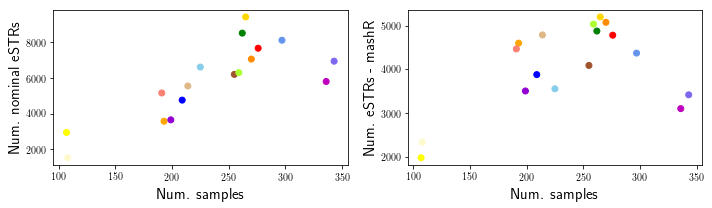

In [40]:
fig = plt.figure()
fig.set_size_inches((10, 3))
ax = fig.add_subplot(121)
ax.scatter([num_samples[t] for t in TISSUES], [numsig_nom[t] for t in TISSUES], color=[COLORS[t] for t in TISSUES])
ax.set_xlabel("Num. samples", size=15)
ax.set_ylabel("Num. nominal eSTRs", size=15);

ax = fig.add_subplot(122)
ax.scatter([num_samples[t] for t in TISSUES], [numsig_mashr[t] for t in TISSUES], color=[COLORS[t] for t in TISSUES])
ax.set_xlabel("Num. samples", size=15)
ax.set_ylabel("Num. eSTRs - mashR", size=15);

fig.tight_layout()
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_SamplePower.pdf"));

In [53]:
numshared = zscores.apply(lambda x: sum(abs(x)>=ZTHRESH), 1) # takes a long time to run

shared across 2 or more tissues: 0.8297232782247369
shared across 10 or more tissues: 0.38847139952258863


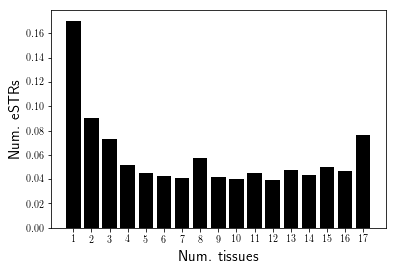

In [62]:
# Tissue sharing
zscores_sig = zscores.copy()
zscores_sig["num"] = numshared
zscores_sig = zscores_sig[zscores_sig["num"]>0]
signum = zscores_sig.groupby("num", as_index=False).agg({"WholeBlood":len})
signum.columns = ["num.tissues", "num.estrs"]
signum["perc.estrs"] = signum["num.estrs"]/sum(signum["num.estrs"])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(signum["num.tissues"], signum["perc.estrs"], color="black");
ax.set_xticks(range(1, ntissues+1));
ax.set_xlabel("Num. tissues", size=15)
ax.set_ylabel("Num. eSTRs", size=15);

if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_TissueSharing.pdf"));
    
print("shared across 2 or more tissues: %s"%(sum(signum[signum["num.tissues"]>=2]["perc.estrs"])))
print("shared across 10 or more tissues: %s"%(sum(signum[signum["num.tissues"]>=10]["perc.estrs"])))

In [69]:
# Pairwise sharing
# Of effects sig in at least one, how many shared within factor of 2
shareMatrix = np.full((ntissues, ntissues), np.nan)
# Correlation of effect sizes
corrMatrix = np.full((ntissues, ntissues), np.nan)

for tissue1 in TISSUES:
    for tissue2 in TISSUES:
        t1ind = TISSUES.index(tissue1)
        t2ind = TISSUES.index(tissue2)
        significant = (zscores[tissue1] >=ZTHRESH) | (zscores[tissue2] >=ZTHRESH)
        sharedEffects = abs(np.log2(betas[tissue1]/betas[tissue2])) < 1
        shareMatrix[t1ind, t2ind] = np.sum(sharedEffects & significant)/np.sum(significant)
        shareMatrix[t2ind, t1ind] = shareMatrix[t1ind, t2ind]
        eff1 = betas[significant][tissue1]
        eff2 = betas[significant][tissue2]
        corrMatrix[t1ind, t2ind] = scipy.stats.spearmanr(eff1, eff2)[0]
        corrMatrix[t2ind, t1ind] = corrMatrix[t1ind, t2ind]

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log2
  if sys.path[0] == '':


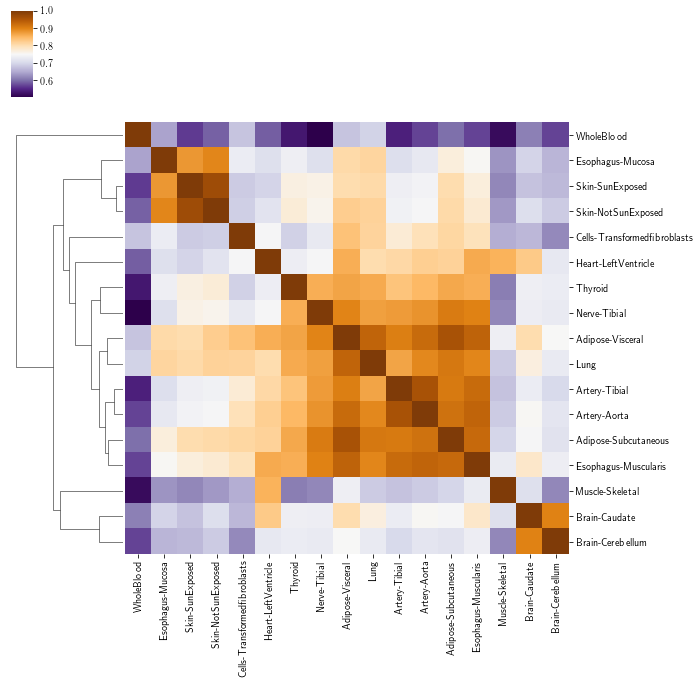

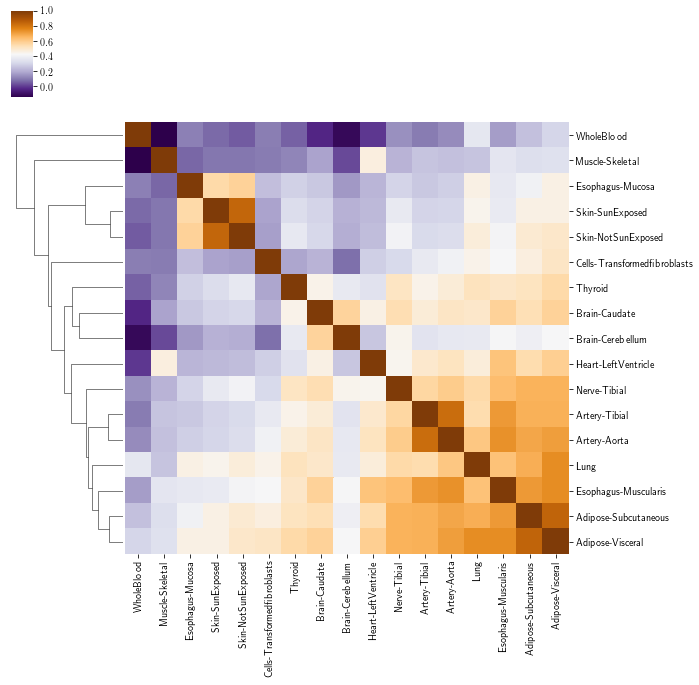

In [70]:
import seaborn as sns
fig = plt.figure()
ax = fig.add_subplot(111)
shareMatrix = pd.DataFrame(shareMatrix, columns=TISSUES, index=TISSUES)
cg = sns.clustermap(shareMatrix, cmap="PuOr_r", ax=ax)
cg.ax_col_dendrogram.set_visible(False)
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "Figure1_mashRHeatmap.pdf"));

fig = plt.figure()
ax = fig.add_subplot(111)
corrMatrix = pd.DataFrame(corrMatrix, columns=TISSUES, index=TISSUES)
cg = sns.clustermap(corrMatrix, cmap="PuOr_r", ax=ax)
cg.ax_col_dendrogram.set_visible(False)
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_mashRHeatmap_spearman.pdf"));

In [94]:
# How do effect sizes compare to those from LCLs?
lcl = master["LCL"]
lclcorr = {}
for t in TISSUES:
    d = master[t]
    d = d[~np.isnan(d["linreg.pval"])].copy()
    d["str.start"] = d["str.start"]+1
    dm = pd.merge(d, lcl, on=["gene","str.start"])
    dm = dm[dm["mashr.significant"] | dm["significant"]]
    lclcorr[t] = scipy.stats.pearsonr(dm["linreg.beta"], dm["beta"])[0]
print("Mean corr with LCL: %s"%(np.mean(list(lclcorr.values()))))
lclcorr

Mean corr with LCL: 0.4754196573054731


{'Adipose-Subcutaneous': 0.49275516428059135,
 'Adipose-Visceral': 0.5080899774899085,
 'Artery-Aorta': 0.4773003372500592,
 'Artery-Tibial': 0.4668212765077246,
 'Brain-Caudate': 0.4192797449106963,
 'Brain-Cerebellum': 0.3427283387212089,
 'Cells-Transformedfibroblasts': 0.5445664933412607,
 'Esophagus-Mucosa': 0.525104778479401,
 'Esophagus-Muscularis': 0.4959887702322874,
 'Heart-LeftVentricle': 0.47866057370493176,
 'Lung': 0.5216064151351223,
 'Muscle-Skeletal': 0.4581445236109402,
 'Nerve-Tibial': 0.44774712177358006,
 'Skin-NotSunExposed': 0.4810366895883935,
 'Skin-SunExposed': 0.4632543416593248,
 'Thyroid': 0.4453366239403053,
 'WholeBlood': 0.5137130035673074}